In [1]:
import os
import torch 
from typing import List
import pandas as pd
import numpy as np
import rasterio
from cloud_model import CloudModel
from PIL import Image
import matplotlib.pyplot as plt
import torchvision.transforms as tv_transform

bands = ["B02", "B03", "B04", "B08"]

In [2]:
# загружаем подготовленный набор изображений и меток с путями
df = pd.read_csv('data/train_metadata_my.csv')
df.head()

chip_id  location                   datetime                   cloudpath  \
0    adwp  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwp   
1    adwu  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwu   
2    adwz  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adwz   
3    adxp  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/adxp   
4    aeaj  Chifunfu  2020-04-29 08:20:47+00:00  az://./train_features/aeaj   

   year                                           B02_path  \
0  2020  J:\CloudCover\data\data\train_features\adwp\B0...   
1  2020  J:\CloudCover\data\data\train_features\adwu\B0...   
2  2020  J:\CloudCover\data\data\train_features\adwz\B0...   
3  2020  J:\CloudCover\data\data\train_features\adxp\B0...   
4  2020  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B03_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B04_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                            B08_path  \
0  J:\CloudCover\data\data\train_features\adwp\B0...   
1  J:\CloudCover\data\data\train_features\adwu\B0...   
2  J:\CloudCover\data\data\train_features\adwz\B0...   
3  J:\CloudCover\data\data\train_features\adxp\B0...   
4  J:\CloudCover\data\data\train_features\aeaj\B0...   

                                      label_path  
0  J:\CloudCover\data\data\train_labels\adwp.tif  
1  J:\CloudCover\data\data\train_labels\adwu.tif  
2  J:\CloudCover\data\data\train_labels\adwz.tif  
3  J:\CloudCover\data\data\train_labels\adxp.tif  
4  J:\CloudCover\data\data\train_labels\aeaj.tif

In [3]:
def load_chip(row, transforms = None):
    data={
        "chip_id":row.iloc[0],
        "image":None,
        "label":None
    }
    band_arrs = []
    for band in row[5:9]:
        with rasterio.open(band) as b:
            band_arr = b.read(1).astype("float32")
        band_arrs.append(band_arr)
    
    # для меток
    with rasterio.open(row[9]) as lp:
        y_arr = lp.read(1).astype("float32")

    # NDVI = (iRed - Red)/(iRed + Red)индекс растительности
    data['ndvi'] = (band_arrs[3] - band_arrs[2])/(band_arrs[3] + band_arrs[2] + 1)
    
    # NDSI = (Green - iRed)/(Green + iRed)индекс снега
    data['ndsi'] = (band_arrs[1] - band_arrs[3])/(band_arrs[1] + band_arrs[3] + 1)

    x_arr = np.stack(band_arrs, axis=-1)
        
    # Apply data augmentations, if provided
    if transforms:
        t = transforms(image = x_arr, mask = y_arr)
        x_arr = t["image"]
        y_arr = t["mask"] 

    data["image"] = np.transpose(x_arr, [2, 0, 1])
    data["label"] = y_arr
    
    return data

In [4]:
import xarray
import numpy as np
from PIL import Image
import xrspatial.multispectral as ms

def get_xarray(filepath):
    """Put images in xarray.DataArray format"""
    im_arr = np.array(Image.open(filepath))
    return xarray.DataArray(im_arr, dims=["y", "x"])

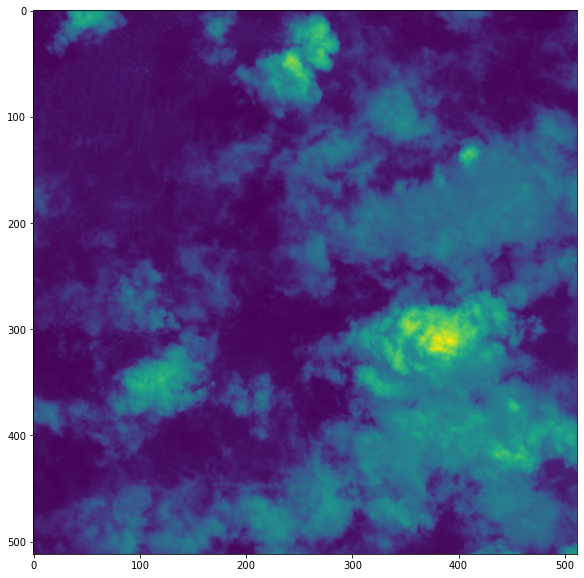

In [6]:
chip = load_chip(df.iloc[1])
plt.gcf().set_size_inches((10,10))
plt.imshow(chip['image'][0])

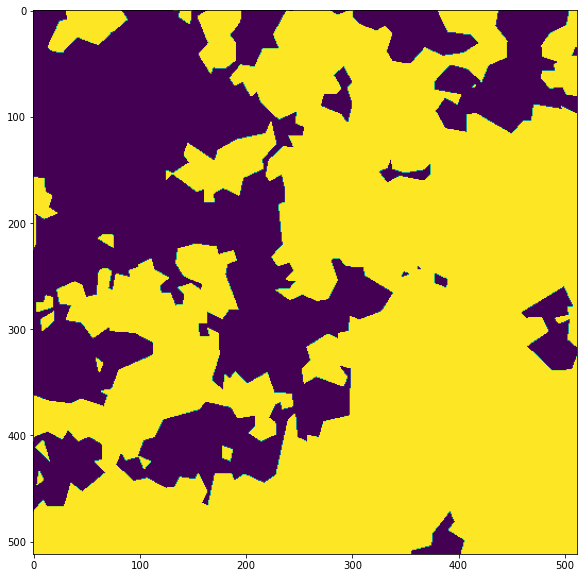

In [7]:
plt.gcf().set_size_inches((10,10))
plt.imshow(chip['label'])

In [12]:
chip['image'].shape

(4, 512, 512)

In [25]:
x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
x_exp = x.expand([1,4,512,512])

In [8]:
# загружаем модель
model = CloudModel(bands=bands, hparams={"weights": None})
model.load_state_dict(torch.load('data/assets/cloud_model_clear.pt'))

<All keys matched successfully>

In [26]:
# применяем модель
pred = model.forward(x_exp)
pred = torch.softmax(pred, dim=1)[:, 1]
pred = (pred > 0.5).detach().numpy().astype("uint8")
# chip_pred_im = Image.fromarray(pred)
# chip_pred_im.save(chip_pred_path)

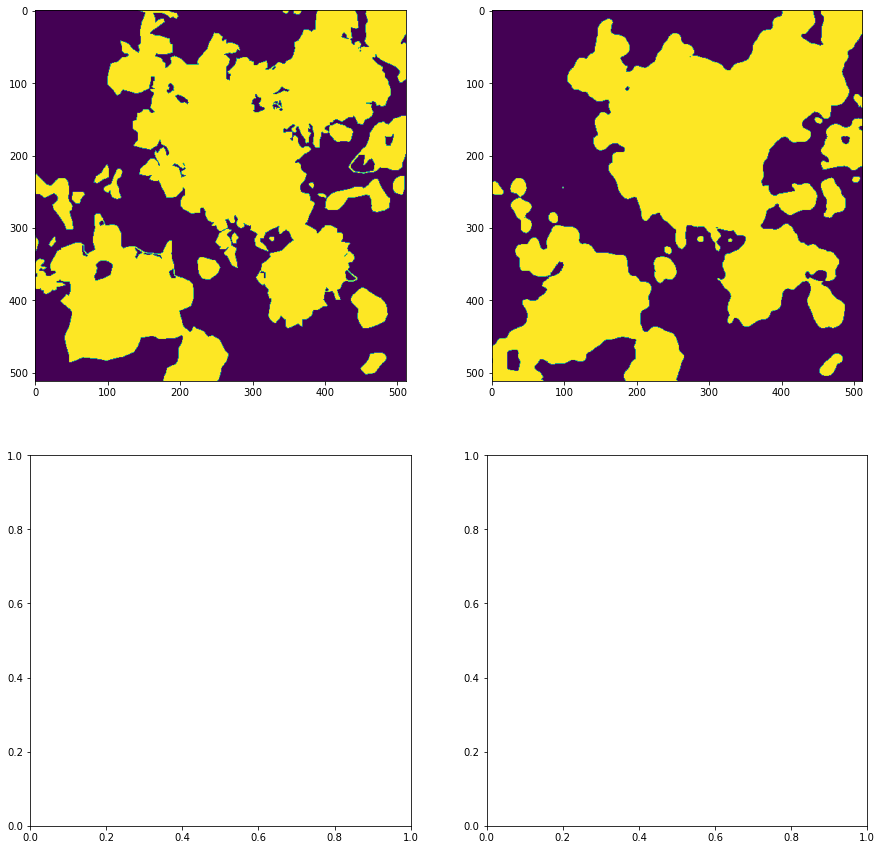

In [34]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

plt.gcf().set_size_inches((15,15))
axes[0, 0].imshow(chip['label'])
axes[0, 1].imshow(pred[0])

In [9]:
# model2 = CloudModel(bands=bands, hparams={"weights": None})
# model2.load_state_dict(torch.load('data/assets/cloud_model_album2.pt'))

<All keys matched successfully>

In [9]:
model2 = CloudModel(bands=bands, hparams={"weights": None})
model2.load_state_dict(torch.load('data/assets/cloud_model_resnet34_final.pt'))

<All keys matched successfully>

In [12]:
model3 = CloudModel(bands=bands, hparams={"backbone":'efficientnet-b0',"weights": None})
model3.load_state_dict(torch.load('data/assets/cloud_model_efnetb0_e10.pt'))

<All keys matched successfully>

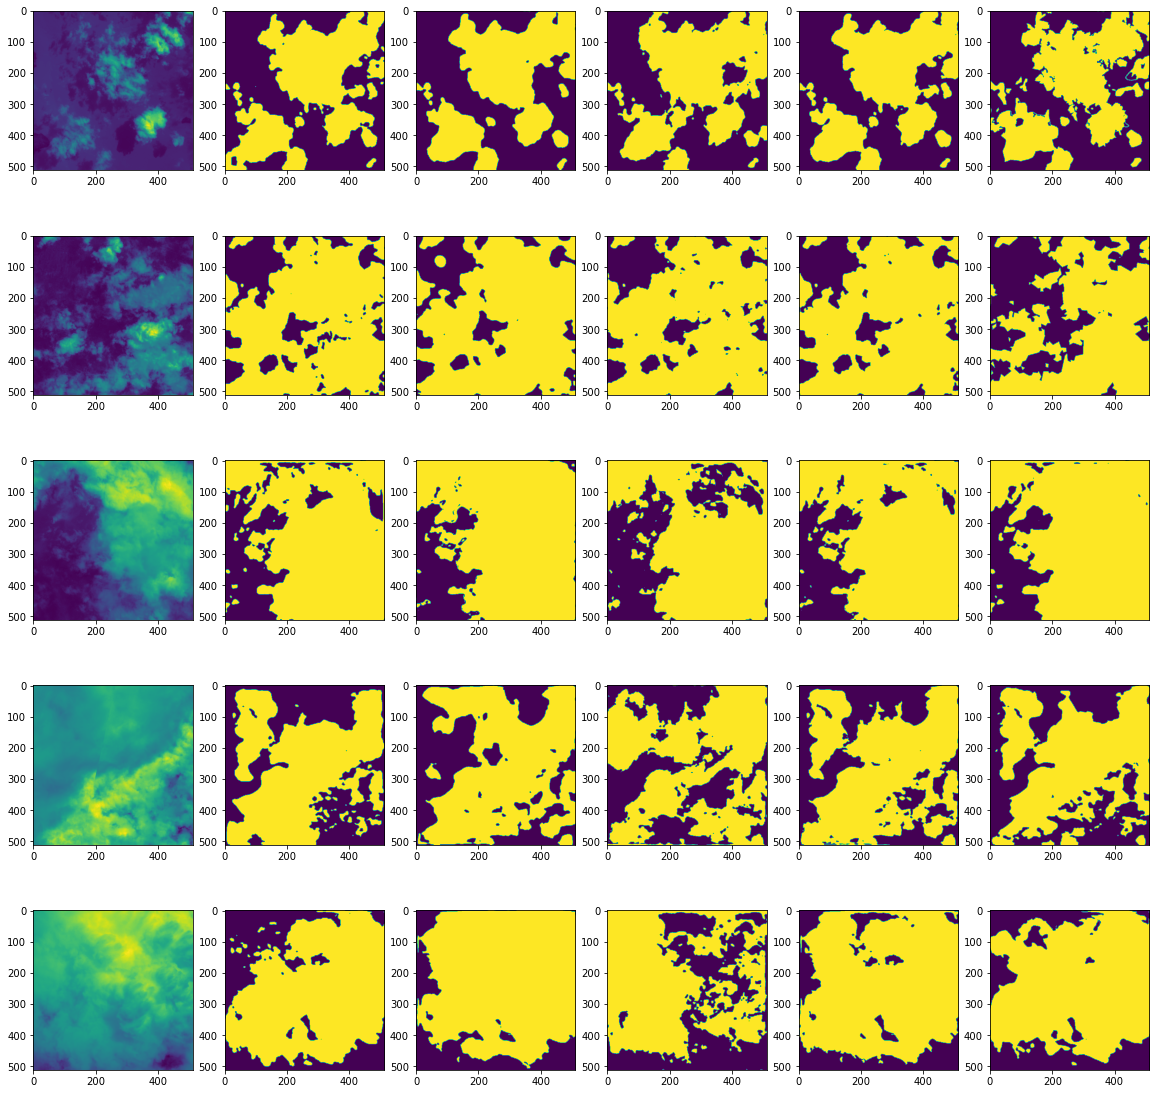

In [16]:
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(15,15))

plt.gcf().set_size_inches((20,20))
for i in range(0, 5):
    chip = load_chip(df.iloc[i])

    x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
    x_exp = x.expand([1,4,512,512])

    pred = model.forward(x_exp)
    pred = torch.softmax(pred, dim=1)[:, 1]
    pred = (pred > 0.5).detach().numpy().astype("uint8")

    pred2 = model2.forward(x_exp)
    pred2 = torch.softmax(pred2, dim=1)[:, 1]
    pred2 = (pred2 > 0.5).detach().numpy().astype("uint8")

    pred3 = model3.forward(x_exp)
    pred3 = torch.softmax(pred3, dim=1)[:, 1]
    pred3 = (pred3 > 0.5).detach().numpy().astype("uint8")
    
    axes[i, 0].imshow(chip["image"][0]);
    axes[i, 1].imshow(pred[0]);
    axes[i, 2].imshow(pred2[0]);
    axes[i, 3].imshow(pred3[0]);
    
    pred4 = np.round((pred[0]+pred2[0]+pred3[0])/3)
    axes[i, 4].imshow(pred4);

    axes[i, 5].imshow(chip["label"]);

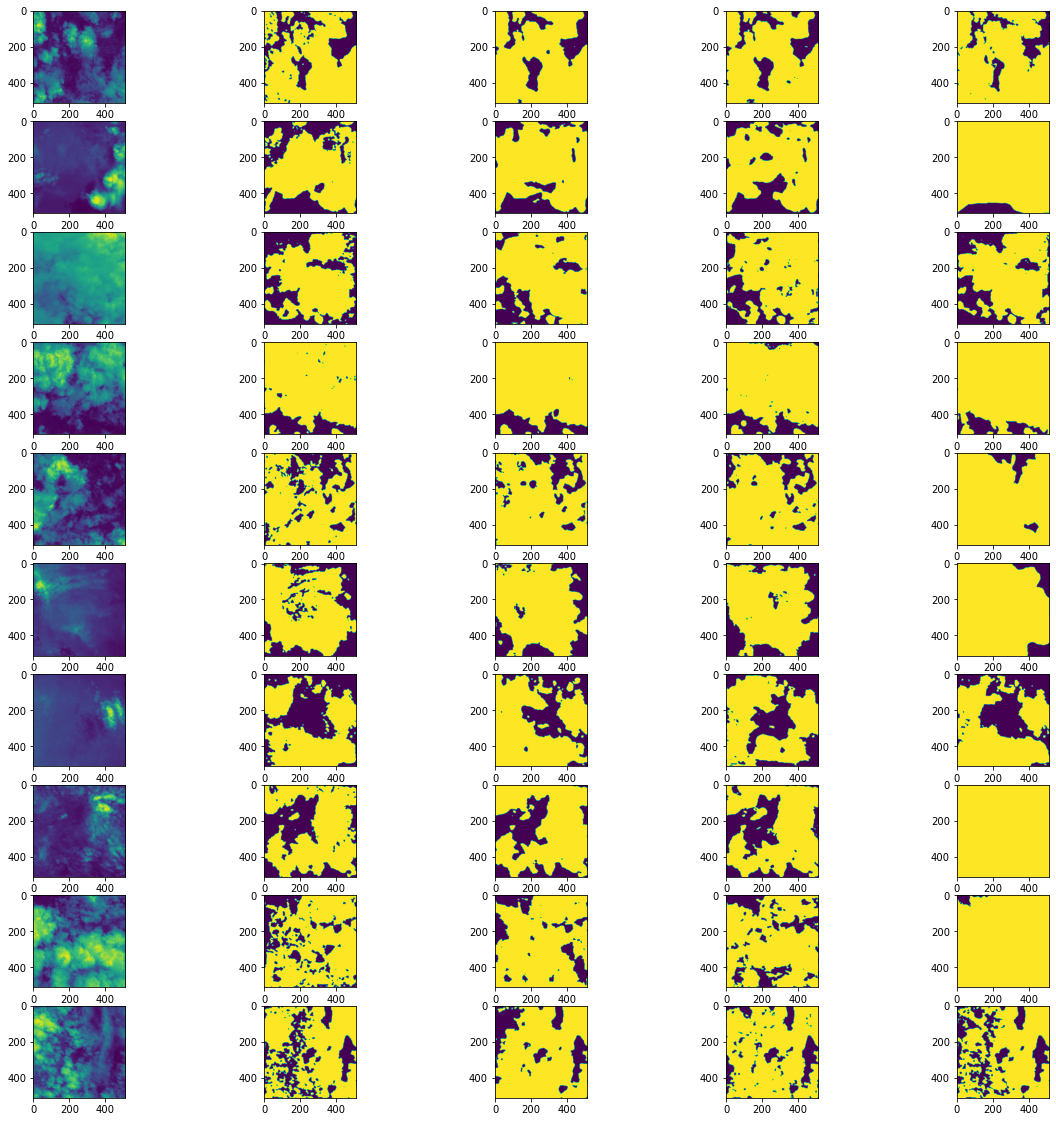

In [13]:
fig, axes = plt.subplots(nrows=10, ncols=5, figsize=(15,15))

plt.gcf().set_size_inches((20,20))
for i,j in enumerate(range(5, 15)):
    chip = load_chip(df.iloc[j])

    x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
    x_exp = x.expand([1,4,512,512])

    pred = model.forward(x_exp)
    pred = torch.softmax(pred, dim=1)[:, 1]
    pred = (pred > 0.5).detach().numpy().astype("uint8")

    pred2 = model2.forward(x_exp)
    pred2 = torch.softmax(pred2, dim=1)[:, 1]
    pred2 = (pred2 > 0.5).detach().numpy().astype("uint8")

    pred3 = model3.forward(x_exp)
    pred3 = torch.softmax(pred3, dim=1)[:, 1]
    pred3 = (pred3 > 0.5).detach().numpy().astype("uint8")
    
    axes[i, 0].imshow(chip["image"][0]);
    axes[i, 1].imshow(pred[0]);
    axes[i, 2].imshow(pred2[0]);
    axes[i, 3].imshow(pred3[0]);
    
    # pred4 = np.round((pred[0]+pred2[0]+pred3[0])/4)
    # axes[i, 4].imshow(pred4);

    axes[i, 4].imshow(chip["label"]);

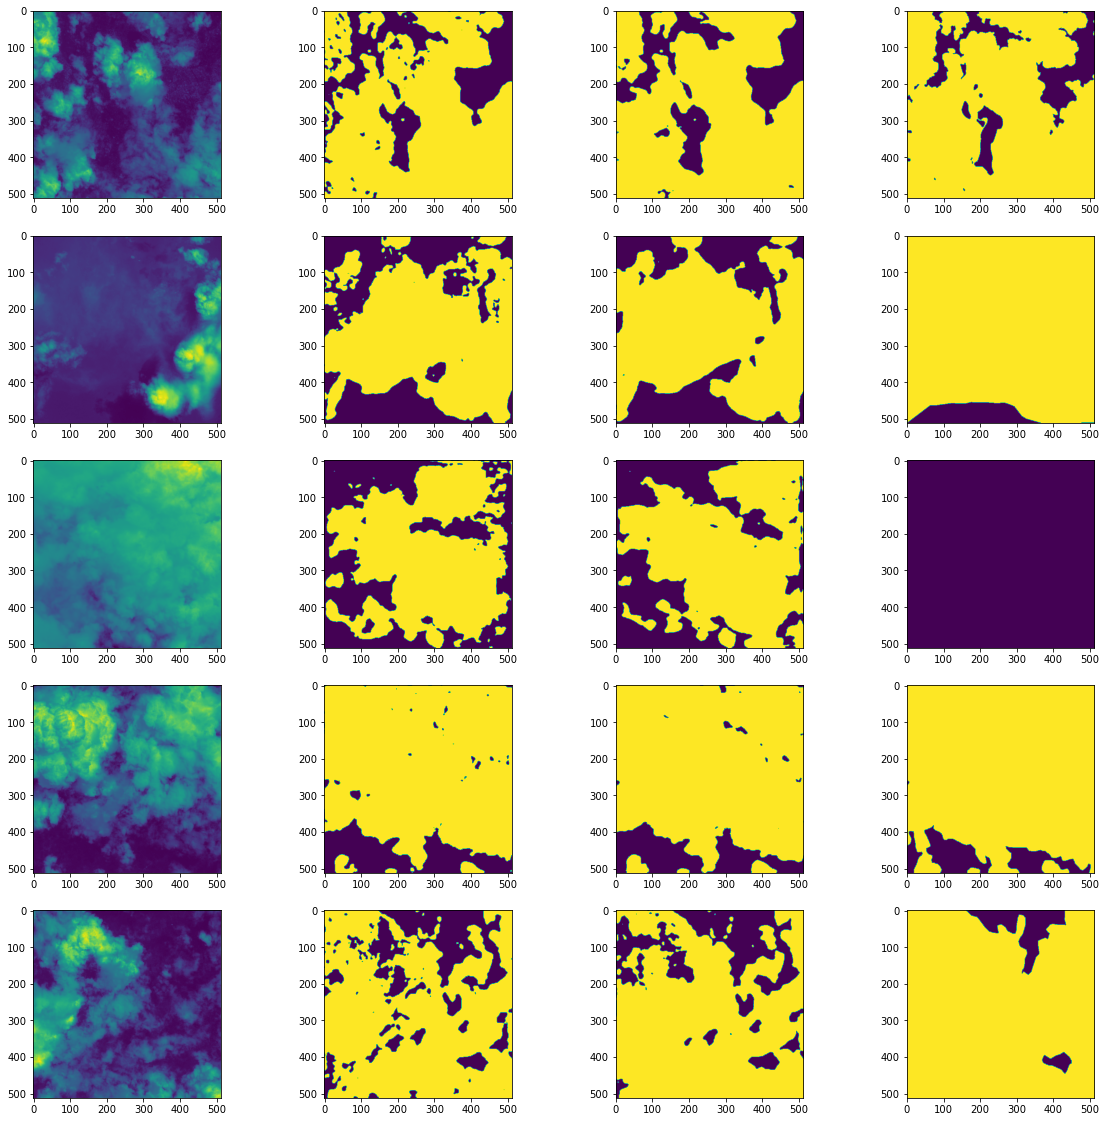

In [51]:
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15,15))

plt.gcf().set_size_inches((20,20))
for i,j in enumerate(list(range(5, 10))):
    chip = load_chip(df.iloc[j])

    x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
    x_exp = x.expand([1,4,512,512])

    pred = model.forward(x_exp)
    pred = torch.softmax(pred, dim=1)[:, 1]
    pred = (pred > 0.5).detach().numpy().astype("uint8")

    pred2 = model2.forward(x_exp)
    pred2 = torch.softmax(pred2, dim=1)[:, 1]
    pred2 = (pred2 > 0.5).detach().numpy().astype("uint8")
    
    axes[i, 0].imshow(chip["image"][0]);
    # axes[i, 1].imshow(chip["image"][1]);
    # axes[i, 2].imshow(chip["image"][2]);
    # axes[i, 3].imshow(chip["image"][3]);
    # axes[i, 4].imshow(chip["image"][4]);
    # axes[i, 5].imshow(chip["image"][5]);
    # axes[i, 6].imshow(chip["image"][6]);
    axes[i, 1].imshow(pred[0]);
    axes[i, 2].imshow(pred2[0]);
    axes[i, 3].imshow(chip["label"]);

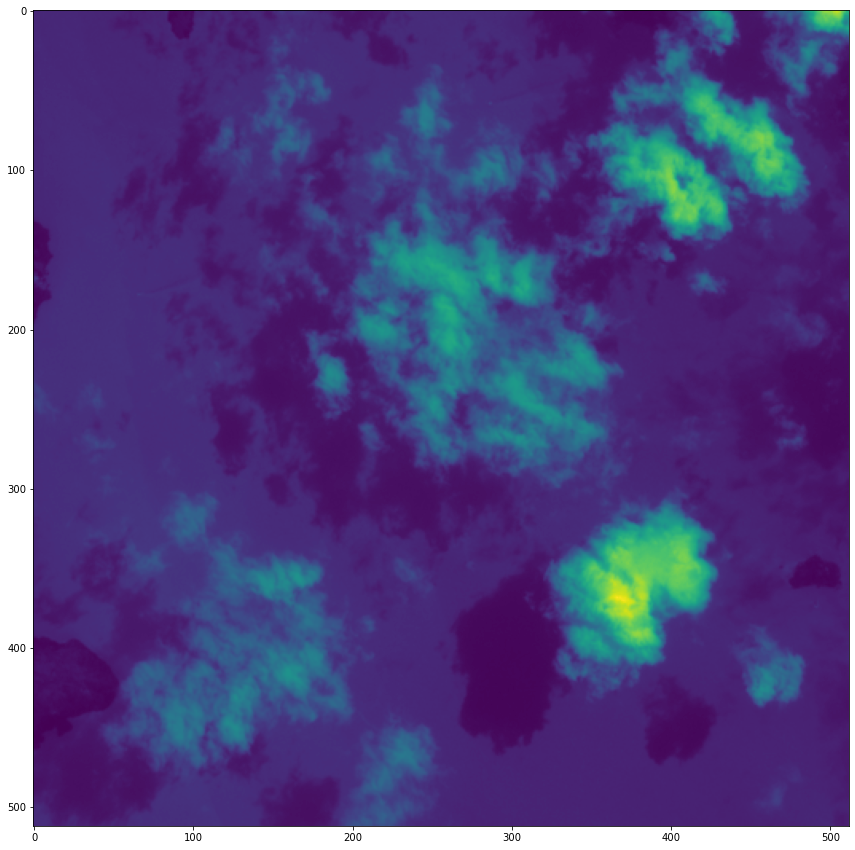

In [60]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches(15,15)
plt.imshow(chip['image'][0])

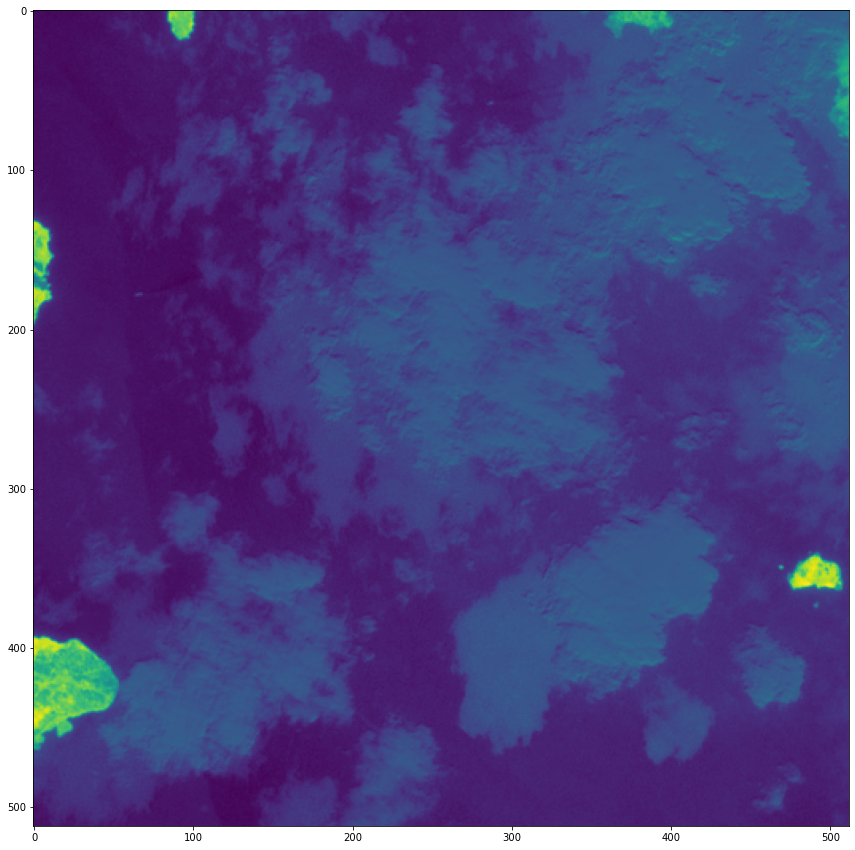

In [61]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches(15,15)
plt.imshow(chip['ndvi'])

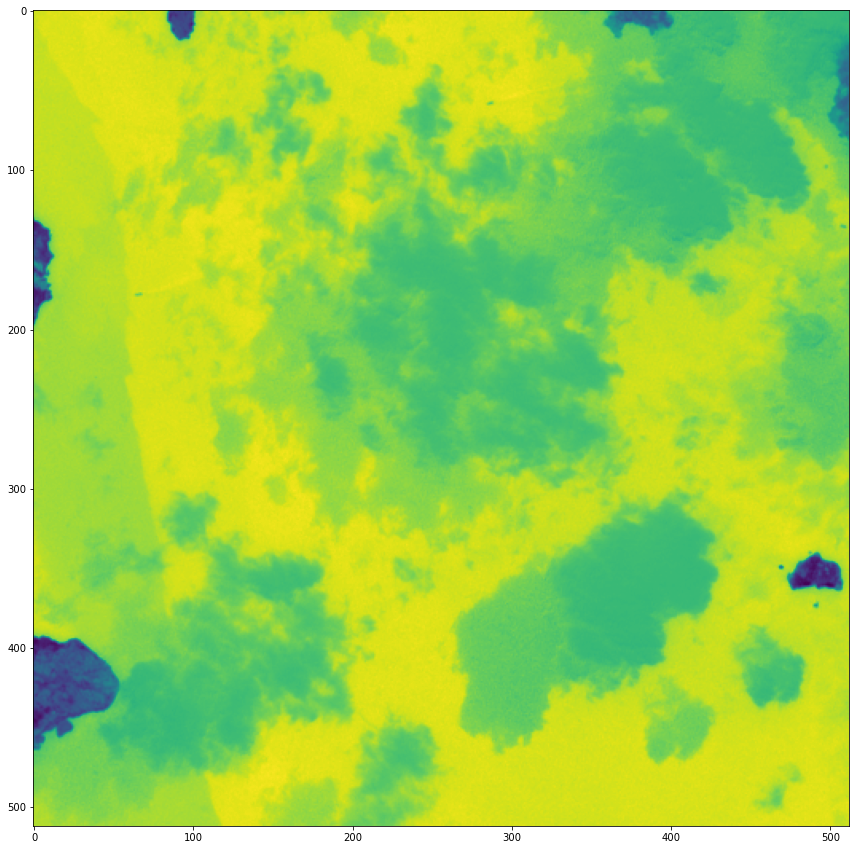

In [4]:
chip = load_chip(df.iloc[0])
plt.gcf().set_size_inches(15,15)
plt.imshow(chip['ndsi'])

(array([ 14.,  16.,  13.,   5.,   2.,   3., 115.,  36.,  71., 237.]),
 array([-0.46759155, -0.38513404, -0.3026765 , -0.22021899, -0.13776147,
        -0.05530395,  0.02715358,  0.10961109,  0.19206862,  0.27452615,
         0.35698366], dtype=float32),
 <BarContainer object of 10 artists>)

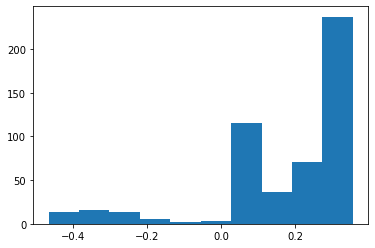

In [9]:
# попробовать инверсию цвета - отследить близкие к нулю значения
import pandas as pd 
plt.hist(chip['ndsi'][0])

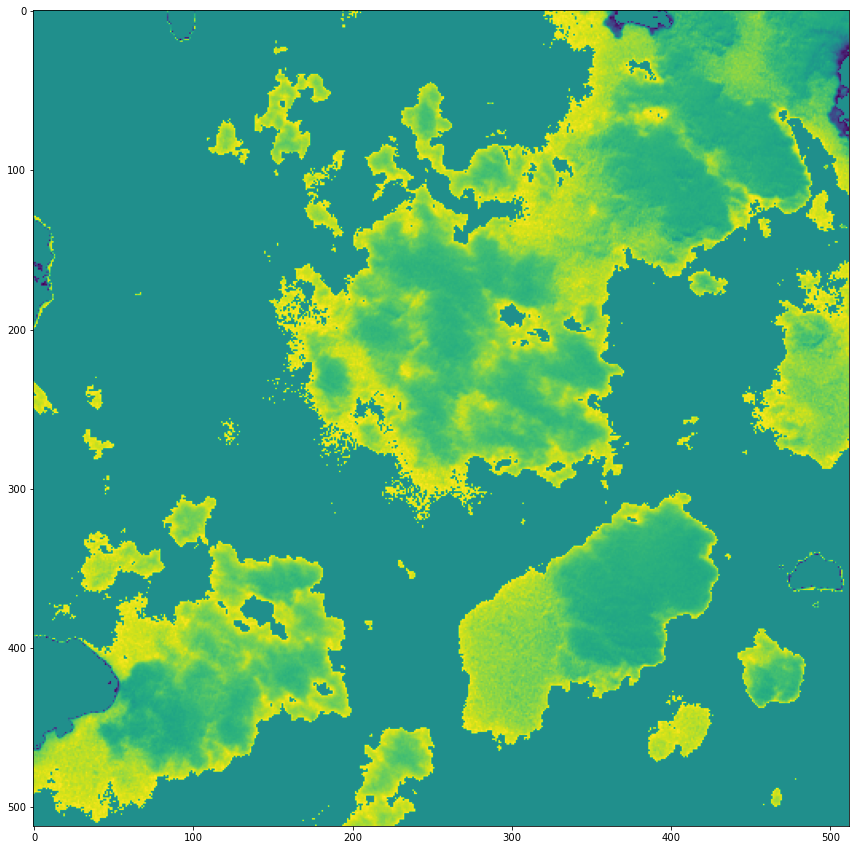

In [31]:
chip = load_chip(df.iloc[0])
a = chip['ndsi']
b = np.where(a < 0.2, a, 0)
b = np.where(-0.2 < b, b, 0)
plt.gcf().set_size_inches(15,15)
plt.imshow(b)

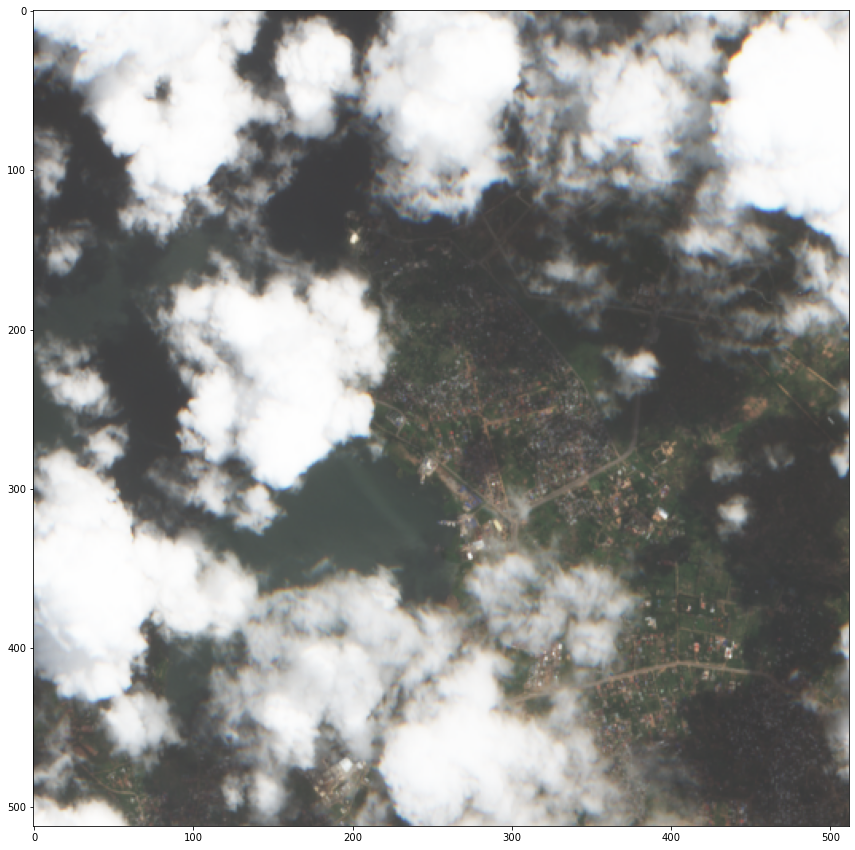

In [166]:
chip = load_chip(df.iloc[29])
red = xarray.DataArray(chip['image'][2], dims=["y", "x"])
green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
blue = xarray.DataArray(chip['image'][0], dims=["y", "x"])
ms1 = ms.true_color(r=red, g=green, b=blue)
plt.gcf().set_size_inches(15,15)
plt.imshow(ms1)

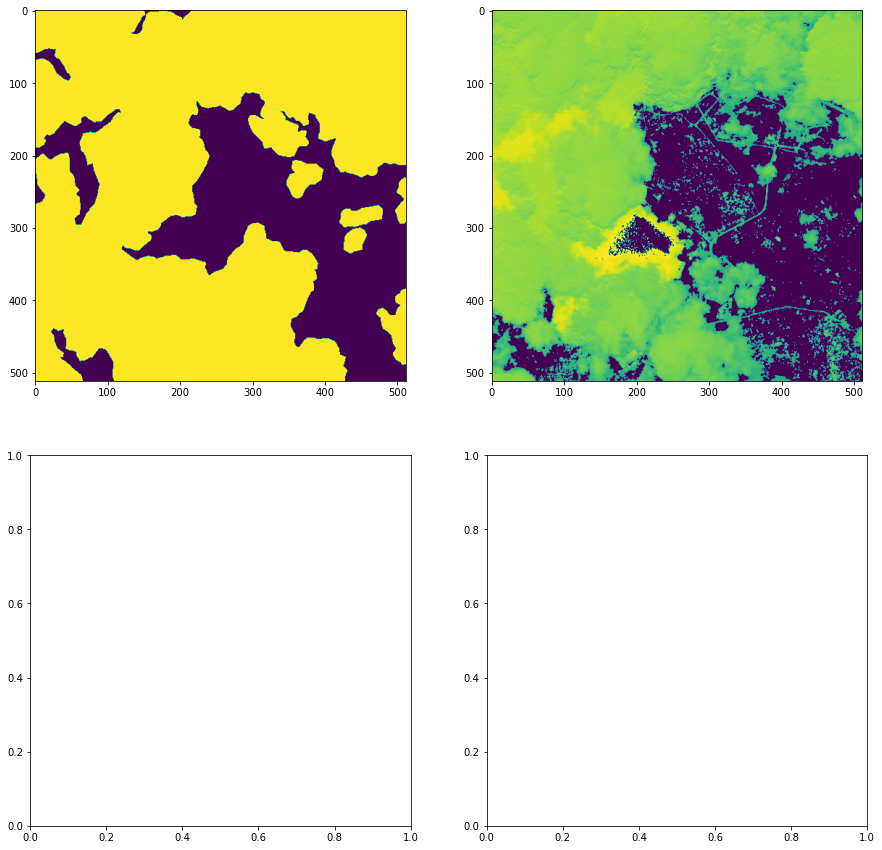

In [165]:
chip = load_chip(df.iloc[29])
a = chip['ndsi']
b = np.where((-0.25 < a) & (a < 0.25), a, -1)
# b = b*3
# plt.gcf().set_size_inches(15,15)
# plt.imshow(b)
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,15))

plt.gcf().set_size_inches((15,15))
axes[0, 0].imshow(chip['label'])
axes[0, 1].imshow(b)

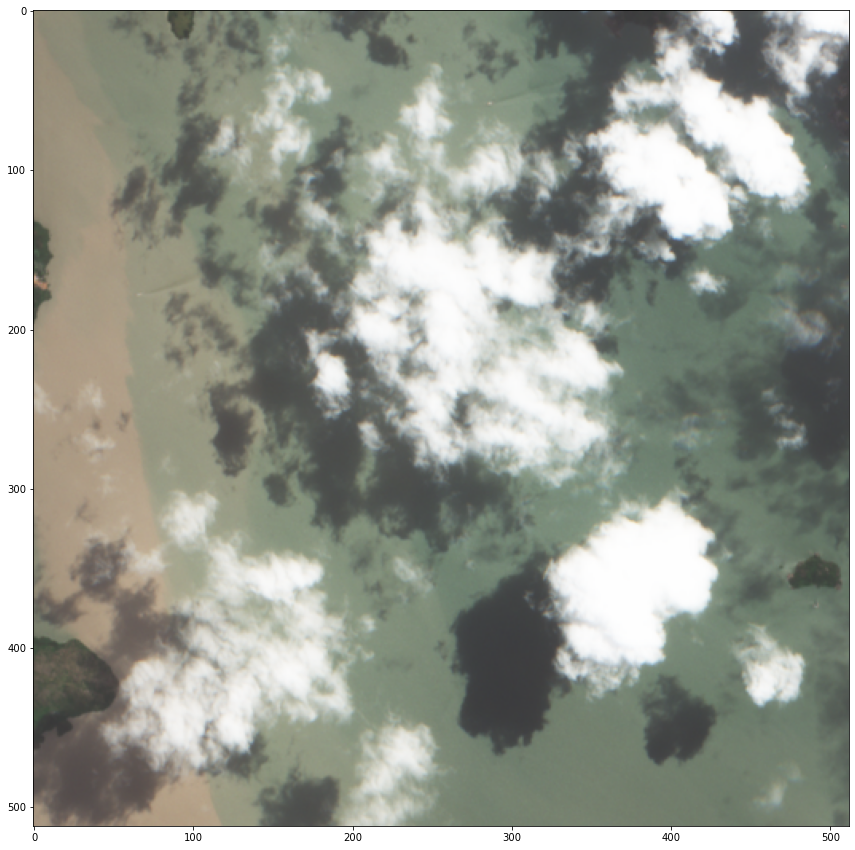

In [19]:
chip = load_chip(df.iloc[0])
red = xarray.DataArray(chip['image'][2], dims=["y", "x"])
green = xarray.DataArray(chip['image'][1], dims=["y", "x"])
blue = xarray.DataArray(chip['image'][0], dims=["y", "x"])
ms1 = ms.true_color(r=red, g=green, b=blue)
plt.gcf().set_size_inches(15,15)
plt.imshow(ms1)

In [ ]:
# Идеи
# 1. Использовать комбинации каналов
# 2. Использовать преобразование в HSV
# 3. Использовать дополнительные данные из Planetary Computer
# 4. Протестировать использование нормализации 
# 5. Сеть другой архитектуры
# 6. Композиция алгоритмов

In [ ]:
# Проверим нормализацию (поделить на 65)

(512, 512)

## Создание меток для неразмеченных изображений - с помощью голосования алгоритмов

In [47]:
# читаем список неразмеченных данных
train_meta_nomark = pd.read_csv('data/train_meta_nomark.csv', index_col='index')
train_meta_nomark.head()

chip_id  location                   datetime  \
index                                                
2        adwz  Chifunfu  2020-04-29 08:20:47+00:00   
3        adxp  Chifunfu  2020-04-29 08:20:47+00:00   
4        aeaj  Chifunfu  2020-04-29 08:20:47+00:00   
7        aebu  Chifunfu  2020-04-29 08:20:47+00:00   
11       aege  Chifunfu  2020-04-29 08:20:47+00:00   

                        cloudpath  year  \
index                                     
2      az://./train_features/adwz  2020   
3      az://./train_features/adxp  2020   
4      az://./train_features/aeaj  2020   
7      az://./train_features/aebu  2020   
11     az://./train_features/aege  2020   

                                                B02_path  \
index                                                      
2      J:\CloudCover\data\data\train_features\adwz\B0...   
3      J:\CloudCover\data\data\train_features\adxp\B0...   
4      J:\CloudCover\data\data\train_features\aeaj\B0...   
7      J:\CloudCover\data\data\train_features\aebu\B0...   
11     J:\CloudCover\data\data\train_features\aege\B0...   

                                                B03_path  \
index                                                      
2      J:\CloudCover\data\data\train_features\adwz\B0...   
3      J:\CloudCover\data\data\train_features\adxp\B0...   
4      J:\CloudCover\data\data\train_features\aeaj\B0...   
7      J:\CloudCover\data\data\train_features\aebu\B0...   
11     J:\CloudCover\data\data\train_features\aege\B0...   

                                                B04_path  \
index                                                      
2      J:\CloudCover\data\data\train_features\adwz\B0...   
3      J:\CloudCover\data\data\train_features\adxp\B0...   
4      J:\CloudCover\data\data\train_features\aeaj\B0...   
7      J:\CloudCover\data\data\train_features\aebu\B0...   
11     J:\CloudCover\data\data\train_features\aege\B0...   

                                                B08_path  \
index                                                      
2      J:\CloudCover\data\data\train_features\adwz\B0...   
3      J:\CloudCover\data\data\train_features\adxp\B0...   
4      J:\CloudCover\data\data\train_features\aeaj\B0...   
7      J:\CloudCover\data\data\train_features\aebu\B0...   
11     J:\CloudCover\data\data\train_features\aege\B0...   

                                          label_path  label_mean  
index                                                             
2      J:\CloudCover\data\data\train_labels\adwz.tif         1.0  
3      J:\CloudCover\data\data\train_labels\adxp.tif         1.0  
4      J:\CloudCover\data\data\train_labels\aeaj.tif         1.0  
7      J:\CloudCover\data\data\train_labels\aebu.tif         1.0  
11     J:\CloudCover\data\data\train_labels\aege.tif         1.0

In [48]:
# Загружаем 3 модели
model = CloudModel(bands=bands, hparams={"backbone":'resnet34', "weights": None})
model.load_state_dict(torch.load('data/assets/cloud_model_album2.pt'))

model2 = CloudModel(bands=bands, hparams={"backbone":'resnet34', "weights": None})
model2.load_state_dict(torch.load('data/assets/cloud_model_resnet34_final.pt'))

model3 = CloudModel(bands=bands, hparams={"backbone":'efficientnet-b0',"weights": None})
model3.load_state_dict(torch.load('data/assets/cloud_model_efnetb0_e10.pt'))

<All keys matched successfully>

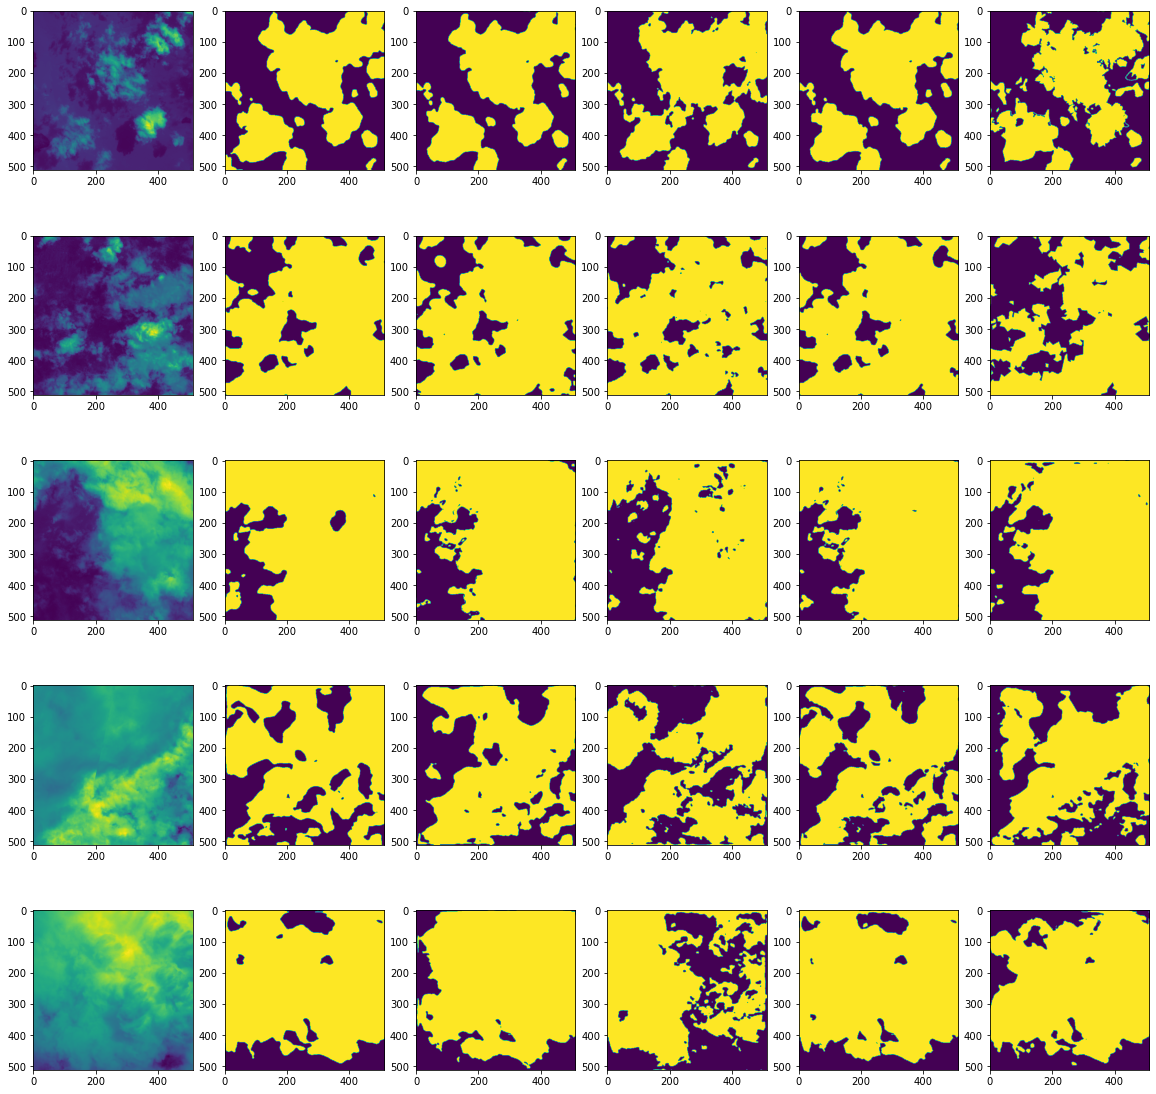

In [51]:
# смотрим что показывают
fig, axes = plt.subplots(nrows=5, ncols=6, figsize=(15,15))

plt.gcf().set_size_inches((20,20))
for i in range(0, 5):
    chip = load_chip(df.iloc[i])

    x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
    x_exp = x.expand([1,4,512,512])

    pred = model.forward(x_exp)
    pred = torch.softmax(pred, dim=1)[:, 1]
    pred = (pred > 0.5).detach().numpy().astype("uint8")

    pred2 = model2.forward(x_exp)
    pred2 = torch.softmax(pred2, dim=1)[:, 1]
    pred2 = (pred2 > 0.5).detach().numpy().astype("uint8")

    pred3 = model3.forward(x_exp)
    pred3 = torch.softmax(pred3, dim=1)[:, 1]
    pred3 = (pred3 > 0.5).detach().numpy().astype("uint8")
    
    axes[i, 0].imshow(chip["image"][0]);
    axes[i, 1].imshow(pred[0]);
    axes[i, 2].imshow(pred2[0]);
    axes[i, 3].imshow(pred3[0]);
    
    pred4 = np.round((pred[0]+pred2[0]+pred3[0])/3)
    axes[i, 4].imshow(pred4);

    axes[i, 5].imshow(chip["label"]);

In [52]:
# создание меток для неразмеченных изображений

for i,row in train_meta_nomark.iterrows():
    chip = load_chip(row)

    x = tv_transform.ToTensor()(np.transpose(chip['image'], [1, 2, 0]))
    x_exp = x.expand([1,4,512,512])

    pred = model.forward(x_exp)
    pred = torch.softmax(pred, dim=1)[:, 1]
    pred = (pred > 0.5).detach().numpy().astype("uint8")

    pred2 = model2.forward(x_exp)
    pred2 = torch.softmax(pred2, dim=1)[:, 1]
    pred2 = (pred2 > 0.5).detach().numpy().astype("uint8")

    pred3 = model3.forward(x_exp)
    pred3 = torch.softmax(pred3, dim=1)[:, 1]
    pred3 = (pred3 > 0.5).detach().numpy().astype("uint8")
    
    pred4 = np.round((pred[0]+pred2[0]+pred3[0])/3)
    print(i)
    chip_pred_im = Image.fromarray(pred4)
    chip_pred_im.save(f"new_labels/{chip['chip_id']}.tif")


2
3
4
7
11
14
20
22
24
25
26
28
30
32
33
35
37
39
40
41
42
46
48
52
53
54
59
70
72
75
76
78
82
84
85
87
91
92
94
104
107
110
111
113
114
115
121
129
131
132
140
141
145
146
147
149
154
158
163
169
171
173
180
181
184
186
187
188
190
192
195
218
243
259
286
343
441
457
467
487
583
639
655
664
666
668
669
670
671
672
673
674
675
676
677
679
680
681
682
684
685
687
688
689
690
692
694
696
699
700
702
703
706
707
709
710
711
712
713
714
715
717
718
719
720
721
722
723
724
725
726
727
730
731
732
733
734
735
736
737
738
739
740
743
746
748
749
752
754
755
757
759
760
761
762
763
764
765
766
767
768
769
770
771
773
774
775
777
778
779
780
781
783
784
785
786
787
788
789
791
793
794
795
796
797
800
801
802
806
808
809
813
814
815
816
817
818
819
820
821
822
823
824
825
827
828
830
831
832
836
837
838
839
840
841
842
844
888
903
923
948
990
996
1006
1007
1008
1021
1022
1023
1028
1029
1036
1037
1041
1044
1053
1058
1076
1077
1090
1122
1136
1146
1148
1151
1173
1232
1234
1240
1250
1257
1266
1267
1